In [2]:
# ==========================================
# 0. SETUP
# ==========================================
import os, math, random, shutil, csv
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder
import torchvision.models as models

# Check device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Paths and constants
DATA_DIR = "/kaggle/input/skin-cancer-mnist-ham10000"
IMG_SIZE = 64
BATCH_SIZE = 32
LATENT_DIM = 100
CLASS_NAMES = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ==========================================
# 1. HAM10000 Dataset Loader + Class Folders
# ==========================================
# Read metadata
meta_csv = Path(DATA_DIR) / "HAM10000_metadata.csv"
imageid_to_class = {}
with open(meta_csv, 'r') as f:
    reader = csv.DictReader(f)
    for r in reader:
        imageid_to_class[r['image_id']] = r['dx'].lower()

# Create per-class folders for real images
real_base = Path("/kaggle/working/real_images")
real_base.mkdir(exist_ok=True)
for cls in CLASS_NAMES:
    (real_base/cls).mkdir(exist_ok=True)

# Copy images into class folders
all_images = list(Path(DATA_DIR).rglob("*.jpg")) + list(Path(DATA_DIR).rglob("*.png"))
for p in all_images:
    stem = p.stem
    if stem in imageid_to_class:
        cls = imageid_to_class[stem]
        if cls in CLASS_NAMES:
            shutil.copy(p, real_base/cls/p.name)

print("Real images organized per class:")
for cls in CLASS_NAMES:
    print(cls, len(list((real_base/cls).glob("*"))))

# ==========================================
# 2. Dataset & Transforms for GAN
# ==========================================
transform_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

class HAMDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = list(Path(folder).rglob("*.jpg")) + list(Path(folder).rglob("*.png"))
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

dataset = HAMDataset(real_base, transform=transform_gan)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ==========================================
# 3. Stage-1: Simple Unconditional GAN
# ==========================================
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=3, img_size=64):
        super().__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Linear(latent_dim, 128*self.init_size**2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels=3, img_size=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*(img_size//4)*(img_size//4), 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        return self.model(img)

G = Generator(LATENT_DIM).to(DEVICE)
D = Discriminator().to(DEVICE)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))

# Train Stage-1 GAN
EPOCHS_STAGE1 = 5  # increase if you have time

# Stage-1 GAN loop (only the z generation part fixed)
for epoch in range(EPOCHS_STAGE1):
    for imgs in dataloader:
        imgs = imgs.to(DEVICE)
        bs = imgs.size(0)
        real_labels = torch.ones(bs,1, device=DEVICE)
        fake_labels = torch.zeros(bs,1, device=DEVICE)

        # Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(bs, LATENT_DIM, device=DEVICE)  # <--- FIXED
        fake_imgs = G(z)
        out_real = D(imgs)
        out_fake = D(fake_imgs.detach())
        loss_D = criterion(out_real, real_labels) + criterion(out_fake, fake_labels)
        loss_D.backward()
        optimizer_D.step()

        # Generator
        optimizer_G.zero_grad()
        out_fake_for_G = D(fake_imgs)
        loss_G = criterion(out_fake_for_G, real_labels)
        loss_G.backward()
        optimizer_G.step()


        

    print(f"Stage-1 Epoch {epoch+1}/{EPOCHS_STAGE1} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

# Save Stage-1 model
torch.save(G.state_dict(), "/kaggle/working/G_stage1.pth")
torch.save(D.state_dict(), "/kaggle/working/D_stage1.pth")

# ==========================================
# 4. Stage-2: Per-class fine-tuning
# ==========================================
class SingleClassDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.paths = img_paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

EPOCHS_STAGE2 = 3  # small to save time
N_SYNTH_PER_CLASS = 200
stage2_dir = Path("/kaggle/working/stage2_synthetic")
stage2_dir.mkdir(exist_ok=True)

for CLASS_NAME in CLASS_NAMES:
    print(f"Fine-tuning Stage-2 for class: {CLASS_NAME}")
    class_paths = list((real_base/CLASS_NAME).glob("*.jpg")) + list((real_base/CLASS_NAME).glob("*.png"))
    class_dataset = SingleClassDataset(class_paths, transform=transform_gan)
    class_loader = DataLoader(class_dataset, batch_size=BATCH_SIZE, shuffle=True)

    G.train()
    D.train()
    for epoch in range(EPOCHS_STAGE2):
        for imgs in class_loader:
            imgs = imgs.to(DEVICE)
            bs = imgs.size(0)
            real_labels = torch.ones(bs,1, device=DEVICE)
            fake_labels = torch.zeros(bs,1, device=DEVICE)

            # Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(bs, LATENT_DIM, device=DEVICE).view(bs,LATENT_DIM,1,1)
            fake_imgs = G(z)
            out_real = D(imgs)
            out_fake = D(fake_imgs.detach())
            loss_D = criterion(out_real, real_labels) + criterion(out_fake, fake_labels)
            loss_D.backward()
            optimizer_D.step()

            # Generator
            optimizer_G.zero_grad()
            out_fake_for_G = D(fake_imgs)
            loss_G = criterion(out_fake_for_G, real_labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Class {CLASS_NAME} | Epoch {epoch+1}/{EPOCHS_STAGE2} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    # Generate Stage-2 synthetic images
    synth_cls_dir = stage2_dir/CLASS_NAME
    synth_cls_dir.mkdir(exist_ok=True)
    G.eval()
    with torch.no_grad():
        for i in range(N_SYNTH_PER_CLASS):
            z = torch.randn(1, LATENT_DIM,1,1, device=DEVICE)
            fake = G(z)
            save_image((fake[0]+1)/2, synth_cls_dir/f"{CLASS_NAME}_{i:04d}.png")
    print(f"Saved {N_SYNTH_PER_CLASS} synthetic images for {CLASS_NAME}")

# ==========================================
# 5. Combine real + synthetic for classifier
# ==========================================
COMBINED_DIR = Path("/kaggle/working/combined_train")
COMBINED_DIR.mkdir(exist_ok=True)
for cls in CLASS_NAMES:
    (COMBINED_DIR/cls).mkdir(exist_ok=True)
    # copy real
    for f in (real_base/cls).glob("*"):
        shutil.copy(f, COMBINED_DIR/cls/f.name)
    # copy synthetic
    for f in (stage2_dir/cls).glob("*"):
        shutil.copy(f, COMBINED_DIR/cls/f.name)

# ==========================================
# 6. Train T-ResNet50 classifier
# ==========================================
train_tf = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset_combined = ImageFolder(COMBINED_DIR, transform=train_tf)
total = len(dataset_combined)
train_sz = int(0.8*total)
val_sz = int(0.1*total)
test_sz = total - train_sz - val_sz
train_ds, val_ds, test_ds = random_split(dataset_combined, [train_sz,val_sz,test_sz])
val_ds.dataset.transform = val_tf
test_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Model
num_classes = len(CLASS_NAMES)
resnet = models.resnet50(weights="IMAGENET1K_V2")
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
)
resnet = resnet.to(DEVICE)
optimizer_cls = optim.Adam(resnet.parameters(), lr=1e-4)
criterion_cls = nn.CrossEntropyLoss()

# Train classifier
EPOCHS_CLS = 3
best_val_acc = 0.0
for epoch in range(EPOCHS_CLS):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer_cls.zero_grad()
        outputs = resnet(imgs)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item()*imgs.size(0)
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss/total
    train_acc = correct/total

    # validation
    resnet.eval()
    val_correct, val_total = 0,0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet(imgs)
            _, preds = torch.max(outputs,1)
            val_correct += (preds==labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct/val_total

    print(f"Epoch {epoch+1}/{EPOCHS_CLS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), "/kaggle/working/t_resnet50_best.pth")
print("Classifier training done. Best val acc:", best_val_acc)

# ==========================================
# 7. Test evaluation + confusion matrix
# ==========================================
from sklearn.metrics import confusion_matrix, classification_report

resnet.load_state_dict(torch.load("/kaggle/working/t_resnet50_best.pth"))
resnet.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = resnet(imgs)
        preds = torch.argmax(outputs,1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())

print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


Using device: cuda
Real images organized per class:
akiec 327
bcc 514
bkl 1099
df 115
mel 1113
nv 6705
vasc 142
Stage-1 Epoch 1/5 | D Loss: 1.0933 | G Loss: 1.7300
Stage-1 Epoch 2/5 | D Loss: 0.7916 | G Loss: 2.6964
Stage-1 Epoch 3/5 | D Loss: 1.4787 | G Loss: 0.5708
Stage-1 Epoch 4/5 | D Loss: 1.1440 | G Loss: 1.8864
Stage-1 Epoch 5/5 | D Loss: 1.2423 | G Loss: 1.1703
Fine-tuning Stage-2 for class: akiec


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3200x1 and 100x32768)

Using device: cuda
Real images per class:
akiec 327
bcc 514
bkl 1099
df 115
mel 1113
nv 6705
vasc 142
Stage-1 Epoch 1/5 | D Loss: 1.2180 | G Loss: 1.1976
Stage-1 Epoch 2/5 | D Loss: 0.8521 | G Loss: 1.3935
Stage-1 Epoch 3/5 | D Loss: 1.4629 | G Loss: 0.8201
Stage-1 Epoch 4/5 | D Loss: 1.3298 | G Loss: 1.9273
Stage-1 Epoch 5/5 | D Loss: 1.4710 | G Loss: 1.1821
Stage-2 Fine-tuning for class: akiec
Class akiec | Epoch 1/3 | D Loss: 2.8927 | G Loss: 0.3433
Class akiec | Epoch 2/3 | D Loss: 1.7473 | G Loss: 0.9294
Class akiec | Epoch 3/3 | D Loss: 1.2582 | G Loss: 2.8626
Saved 200 synthetic images for akiec
Stage-2 Fine-tuning for class: bcc
Class bcc | Epoch 1/3 | D Loss: 1.7869 | G Loss: 1.8930
Class bcc | Epoch 2/3 | D Loss: 2.2462 | G Loss: 0.1640
Class bcc | Epoch 3/3 | D Loss: 3.4408 | G Loss: 1.0472
Saved 200 synthetic images for bcc
Stage-2 Fine-tuning for class: bkl
Class bkl | Epoch 1/3 | D Loss: 1.6101 | G Loss: 1.5773
Class bkl | Epoch 2/3 | D Loss: 1.6388 | G Loss: 0.4336
Class

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


Epoch 1/3 | Train Loss: 0.9007 | Train Acc: 0.6701 | Val Acc: 0.7607
Epoch 2/3 | Train Loss: 0.4829 | Train Acc: 0.8321 | Val Acc: 0.8195
Epoch 3/3 | Train Loss: 0.2715 | Train Acc: 0.9100 | Val Acc: 0.8510
Classifier training done. Best val acc: 0.8510078878177038
              precision    recall  f1-score   support

       akiec     0.8214    0.7797    0.8000        59
         bcc     0.7179    0.9333    0.8116        60
         bkl     0.8175    0.7518    0.7833       137
          df     0.7241    0.7000    0.7119        30
         mel     0.6275    0.5517    0.5872       116
          nv     0.9177    0.9323    0.9249       694
        vasc     0.9130    0.9130    0.9130        46

    accuracy                         0.8573      1142
   macro avg     0.7913    0.7946    0.7903      1142
weighted avg     0.8555    0.8573    0.8552      1142



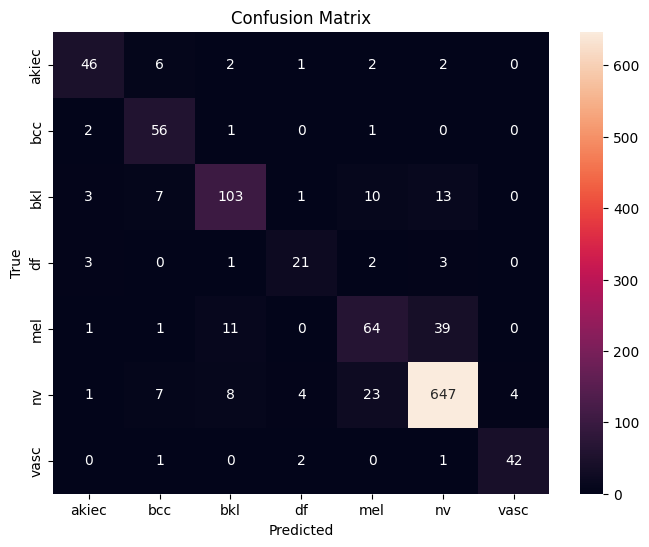

In [3]:
# ==========================================
# 0. SETUP
# ==========================================
import os, math, random, shutil, csv
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import torchvision.models as models

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Paths and constants
DATA_DIR = "/kaggle/input/skin-cancer-mnist-ham10000"
IMG_SIZE = 64
BATCH_SIZE = 32
LATENT_DIM = 100
CLASS_NAMES = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ==========================================
# 1. ORGANIZE HAM10000 DATASET
# ==========================================
meta_csv = Path(DATA_DIR) / "HAM10000_metadata.csv"
imageid_to_class = {}
with open(meta_csv, 'r') as f:
    reader = csv.DictReader(f)
    for r in reader:
        imageid_to_class[r['image_id']] = r['dx'].lower()

# Create per-class folders
real_base = Path("/kaggle/working/real_images")
real_base.mkdir(exist_ok=True)
for cls in CLASS_NAMES:
    (real_base/cls).mkdir(exist_ok=True)

# Copy images into class folders
all_images = list(Path(DATA_DIR).rglob("*.jpg")) + list(Path(DATA_DIR).rglob("*.png"))
for p in all_images:
    stem = p.stem
    if stem in imageid_to_class:
        cls = imageid_to_class[stem]
        if cls in CLASS_NAMES:
            shutil.copy(p, real_base/cls/p.name)

print("Real images per class:")
for cls in CLASS_NAMES:
    print(cls, len(list((real_base/cls).glob("*"))))

# ==========================================
# 2. DATASET + TRANSFORMS
# ==========================================
transform_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

class HAMDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = list(Path(folder).rglob("*.jpg")) + list(Path(folder).rglob("*.png"))
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

dataset = HAMDataset(real_base, transform=transform_gan)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ==========================================
# 3. STAGE-1: SIMPLE GAN
# ==========================================
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=3, img_size=64):
        super().__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Linear(latent_dim, 128*self.init_size**2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3, img_size=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*(img_size//4)*(img_size//4), 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        return self.model(img)

G = Generator(LATENT_DIM).to(DEVICE)
D = Discriminator().to(DEVICE)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))

# Train Stage-1 GAN
EPOCHS_STAGE1 = 5
for epoch in range(EPOCHS_STAGE1):
    for imgs in dataloader:
        imgs = imgs.to(DEVICE)
        bs = imgs.size(0)
        real_labels = torch.ones(bs,1, device=DEVICE)
        fake_labels = torch.zeros(bs,1, device=DEVICE)

        # Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(bs, LATENT_DIM, device=DEVICE)
        fake_imgs = G(z)
        loss_D = criterion(D(imgs), real_labels) + criterion(D(fake_imgs.detach()), fake_labels)
        loss_D.backward()
        optimizer_D.step()

        # Generator
        optimizer_G.zero_grad()
        loss_G = criterion(D(fake_imgs), real_labels)
        loss_G.backward()
        optimizer_G.step()

    print(f"Stage-1 Epoch {epoch+1}/{EPOCHS_STAGE1} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

# Save Stage-1
torch.save(G.state_dict(), "/kaggle/working/G_stage1.pth")
torch.save(D.state_dict(), "/kaggle/working/D_stage1.pth")

# ==========================================
# 4. STAGE-2: PER-CLASS FINETUNING
# ==========================================
class SingleClassDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.paths = img_paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

EPOCHS_STAGE2 = 3
N_SYNTH_PER_CLASS = 200
stage2_dir = Path("/kaggle/working/stage2_synthetic")
stage2_dir.mkdir(exist_ok=True)

for cls_name in CLASS_NAMES:
    print(f"Stage-2 Fine-tuning for class: {cls_name}")
    class_paths = list((real_base/cls_name).glob("*"))
    class_dataset = SingleClassDataset(class_paths, transform=transform_gan)
    class_loader = DataLoader(class_dataset, batch_size=BATCH_SIZE, shuffle=True)

    G.train()
    D.train()
    for epoch in range(EPOCHS_STAGE2):
        for imgs in class_loader:
            imgs = imgs.to(DEVICE)
            bs = imgs.size(0)
            real_labels = torch.ones(bs,1, device=DEVICE)
            fake_labels = torch.zeros(bs,1, device=DEVICE)

            # Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(bs, LATENT_DIM, device=DEVICE)  # 2D shape, no .view()
            fake_imgs = G(z)
            loss_D = criterion(D(imgs), real_labels) + criterion(D(fake_imgs.detach()), fake_labels)
            loss_D.backward()
            optimizer_D.step()

            # Generator
            optimizer_G.zero_grad()
            loss_G = criterion(D(fake_imgs), real_labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Class {cls_name} | Epoch {epoch+1}/{EPOCHS_STAGE2} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    # Generate synthetic images
    synth_cls_dir = stage2_dir/cls_name
    synth_cls_dir.mkdir(exist_ok=True)
    G.eval()
    with torch.no_grad():
        for i in range(N_SYNTH_PER_CLASS):
            z = torch.randn(1, LATENT_DIM, device=DEVICE)
            fake = G(z)
            save_image((fake[0]+1)/2, synth_cls_dir/f"{cls_name}_{i:04d}.png")
    print(f"Saved {N_SYNTH_PER_CLASS} synthetic images for {cls_name}")

# ==========================================
# 5. COMBINE REAL + SYNTHETIC
# ==========================================
COMBINED_DIR = Path("/kaggle/working/combined_train")
COMBINED_DIR.mkdir(exist_ok=True)
for cls in CLASS_NAMES:
    (COMBINED_DIR/cls).mkdir(exist_ok=True)
    for f in (real_base/cls).glob("*"):
        shutil.copy(f, COMBINED_DIR/cls/f.name)
    for f in (stage2_dir/cls).glob("*"):
        shutil.copy(f, COMBINED_DIR/cls/f.name)

# ==========================================
# 6. TRAIN T-RESNET50 CLASSIFIER
# ==========================================
train_tf = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset_combined = ImageFolder(COMBINED_DIR, transform=train_tf)
total = len(dataset_combined)
train_sz = int(0.8*total)
val_sz = int(0.1*total)
test_sz = total - train_sz - val_sz
train_ds, val_ds, test_ds = random_split(dataset_combined, [train_sz,val_sz,test_sz])
val_ds.dataset.transform = val_tf
test_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

resnet = models.resnet50(weights="IMAGENET1K_V2")
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, len(CLASS_NAMES))
)
resnet = resnet.to(DEVICE)
optimizer_cls = optim.Adam(resnet.parameters(), lr=1e-4)
criterion_cls = nn.CrossEntropyLoss()

EPOCHS_CLS = 3
best_val_acc = 0.0
for epoch in range(EPOCHS_CLS):
    # Training
    resnet.train()
    running_loss, correct, total = 0,0,0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer_cls.zero_grad()
        outputs = resnet(imgs)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item()*imgs.size(0)
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss/total
    train_acc = correct/total

    # Validation
    resnet.eval()
    val_correct, val_total = 0,0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet(imgs)
            _, preds = torch.max(outputs,1)
            val_correct += (preds==labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct/val_total

    print(f"Epoch {epoch+1}/{EPOCHS_CLS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), "/kaggle/working/t_resnet50_best.pth")
print("Classifier training done. Best val acc:", best_val_acc)

# ==========================================
# 7. TEST EVALUATION
# ==========================================
from sklearn.metrics import confusion_matrix, classification_report

resnet.load_state_dict(torch.load("/kaggle/working/t_resnet50_best.pth"))
resnet.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = resnet(imgs)
        preds = torch.argmax(outputs,1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())

print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()
